In [1]:
import os
import logging
import shutil

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from skimage import io, transform, color

In [3]:
logging.basicConfig(encoding='utf-8', level=logging.INFO, format="%(asctime)s - %(levelname)s: %(message)s", datefmt='%Y/%m/%d %H:%M:%S')
logger = logging.getLogger(__name__)

# Bases for dataset
[Torch tuto](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html): `https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html`

# Transforms

In [24]:
class SampleShapeError(Exception):
    def __init__(self, message):            
        # Call the base class constructor with the parameters it needs
        super().__init__(message)

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, the image height is matched
            to output_size, while keeping aspect ratio the same.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape
        if isinstance(self.output_size, int):
            new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)

        return transform.resize(image, (new_h, new_w))


class CropVerticalStripe(object):
    """Extract a vertical stripe of an image in a sample.
    Args:
        center (int): the column where the middle
            of the stripe is located.
        width (int): Desired width of the stripe.
            If the width is an even number, the center will be slightly
            to the left of the stripe.
            
    """

    def __init__(self, width):
        assert isinstance(width, int)
        self.width = width

    def __call__(self, sample, center):
        img = sample['image']
        
        if self.width % 2 == 0:
            left = center - self.width//2 + 1
            right = center + self.width//2
        else:
            left = center - self.width//2
            right = center + self.width//2
        
        # Ensuring the bounds are within the image
        if (left < 0) or (right >= img.shape[1]):
            raise SampleShapeError(f"Cannot extract a crop of width {self.width} " \
                                   f"from a sample of width {img.shape[1]}")

        img = img[:, left:right+1]

        return {"image": img, "label": sample["label"]}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        img, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        if len(img.shape)==3:
            img = img.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(img),
                'label': torch.from_numpy(label)}

# Dataset class

In [25]:
class MangaPagesDataset(torch.utils.data.Dataset):
    """Manga Pages dataset."""

    def __init__(self, csv_file, root_dir, seed=42, sample_shape=(1200, 300)):
        """
        Initiates the Dataset. The files considered should not contain
            double pages splitted in two distinct files 
        Arguments:
            csv_file (string): Path to the csv file containing data o.
                The files name should be ordered inside a same tome/volume.
                Contains columns ['File_name', 'Manga', 'Volume'] before
                initialization.
            root_dir (string): Directory with all the images.
            seed (int): seed used for reproductibility when creating random samples.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.seed = seed
        self.sample_shape = sample_shape
        self.create_labels(self.seed)
        
        self.rescale = Rescale(self.sample_shape[0])
        self.crop = CropVerticalStripe(self.sample_shape[1])
    
    def __len__(self):
        return len(self.df)

    #TODO: if we merge two pages with a different column number,
    # then we should not look at the middle for the junction
    #TODO if __getitem__ gets a list?
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.df.loc[idx, "File_name"])
        
        if self.df.loc[idx, "is_double_page"]:
            img = self.imread(img_name)
            junction = np.nan
        else:
            # We create an image [File_name, pairing]
            # So that if img_X is paired with img_X+1
            # and img_X+1 is paired with img_X
            # we get two different double images.
            
            img_1_name = os.path.join(self.root_dir,
                                      self.df.loc[idx, "pairing"])
            
            img_0 = self.imread(img_name)
            img_1 = self.imread(img_1_name)
            
            img = np.hstack((img_0, img_1))
            
            junction = img_0.shape[1] / img.shape[1]
        
        """#TODO: look at what the resize transform does to the bounds!
        if self.transform:
            sample = self.transform(sample)
        """
        
        sample = {"image": img, "label": int(self.df.loc[idx, "is_double_page"])}

        return sample
    
    
    def imread(self, img_name):
        # Cannot do 'as_gray=True' as there is no way of knowing
        # if the image has been normalized or not with only skimage
        img = io.imread(img_name)
        
        if len(img.shape)>2:
            return self.rescale(color.rgb2gray(img).astype(np.float32))
        else:
            return self.rescale(img.astype(np.float32) / 255.)

    
    def create_labels(self, seed):
        """
        Generating labels for the dataset, generating something like
                File_name 	                       Manga 	  Volume   is_double_page 	       pairing
        0 	Abara-Deluxe-2023_T1_001.jpg 	Abara-Deluxe-2023 	T1 	         0 	       Abara-Deluxe-2023_T1_002.jpg
        1 	Abara-Deluxe-2023_T1_002.jpg 	Abara-Deluxe-2023 	T1 	         1 	
        2 	Abara-Deluxe-2023_T1_003.jpg 	Abara-Deluxe-2023 	T1 	         1 	
        3 	Abara-Deluxe-2023_T1_004.jpg 	Abara-Deluxe-2023 	T1 	         0 	       Abara-Deluxe-2023_T1_005.jpg
        4 	Abara-Deluxe-2023_T1_005.jpg 	Abara-Deluxe-2023 	T1 	         0 	       Abara-Deluxe-2023_T1_004.jpg
        """
        
        generator = np.random.default_rng(seed=seed)
        
        # Generating labels, if 1 then it is a double page
        # if 0 then the file is not a double page and should be
        # associated with another page
        self.df["is_double_page"] = generator.integers(2, size=len(self.df)).astype(dtype=np.bool_)
        
        # Generating other pair value when sample is not a double page
        self.df["pairing"] = ""
        for manga in pd.unique(self.df["Manga"]):
            sub_df = self.df[self.df["Manga"]==manga]
            for volume in pd.unique(sub_df["Volume"]):
                sub_sub_df = sub_df[sub_df["Volume"]==volume]
                for idx in sub_sub_df[~sub_sub_df["is_double_page"]].index:
                    consecutive = []
                    if idx-1 in sub_sub_df.index:
                        consecutive += [idx-1]
                    if idx+1 in sub_sub_df.index:
                        consecutive += [idx+1]
                    elif consecutive==[]:
                        consecutive = [idx]
                    self.df.loc[idx, "pairing"] = self.df.loc[generator.choice(consecutive, 1)[0], "File_name"]

In [26]:
ds = MangaPagesDataset(csv_file='/Users/romanmalinowski/Code/Classifier_manga/data/images_data.csv',
                       root_dir='/Users/romanmalinowski/Code/Classifier_manga/data/images')

2025/01/17 13:12:11 - INFO: Abara-Deluxe-2023


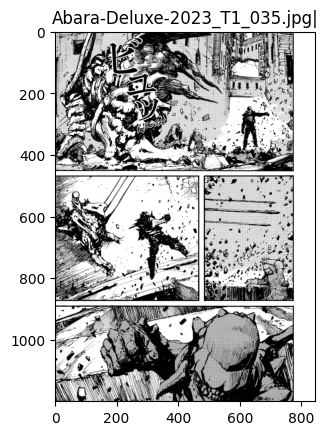

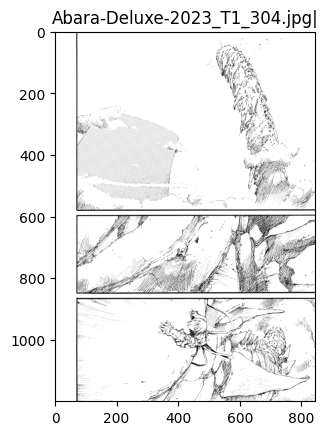

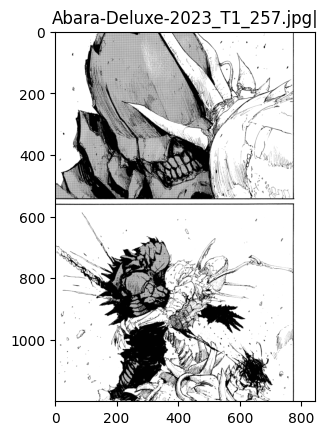

2025/01/17 13:12:13 - INFO: Berserk


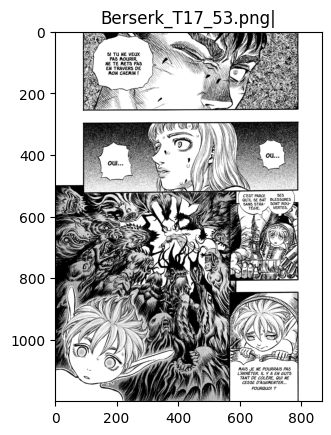

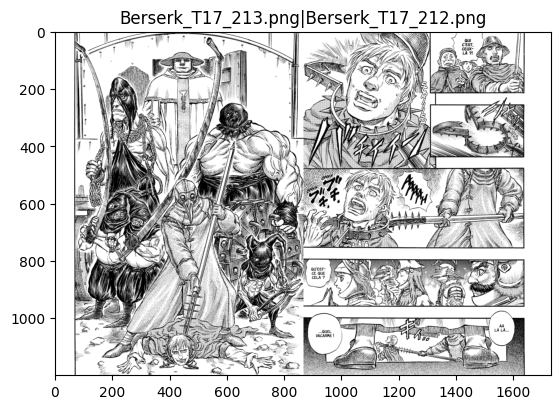

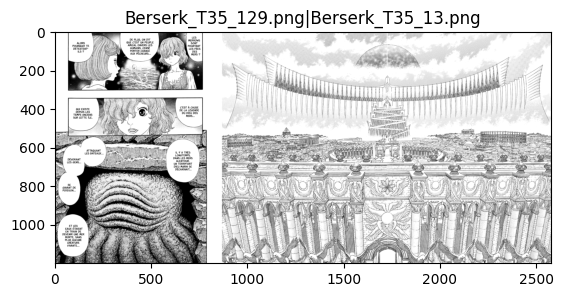

2025/01/17 13:12:15 - INFO: Chainsaw-Man


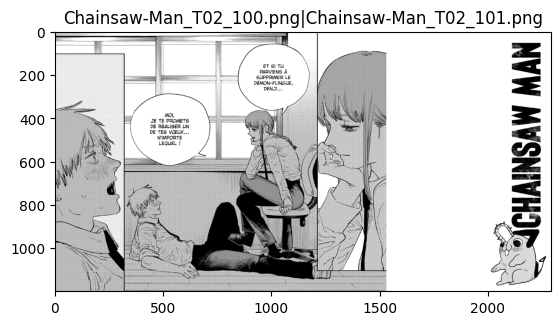

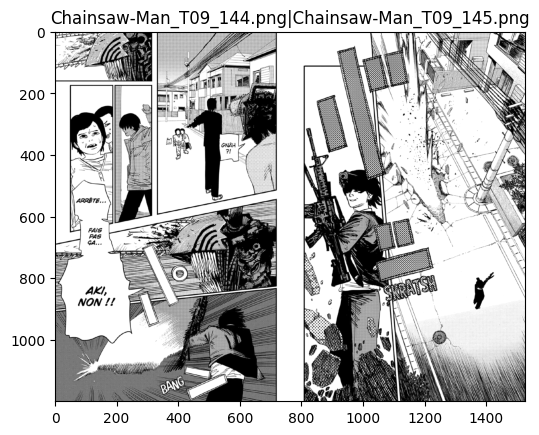

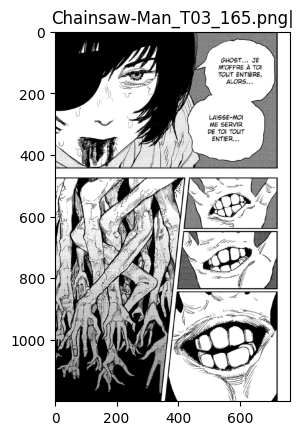

2025/01/17 13:12:17 - INFO: Dandadan


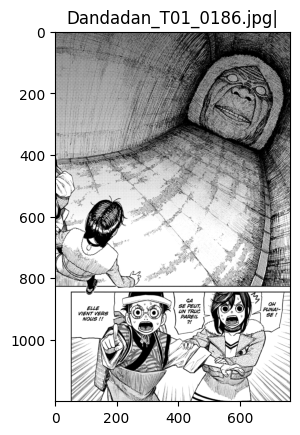

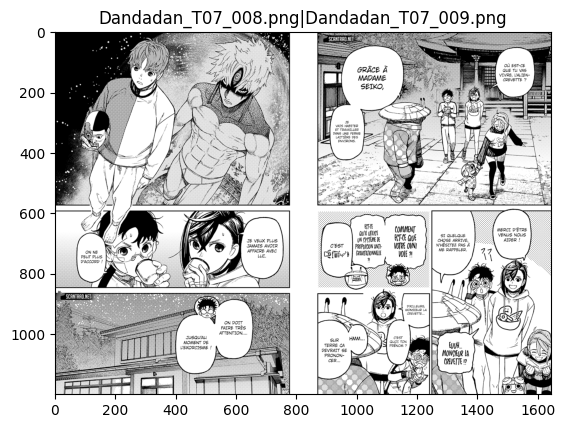

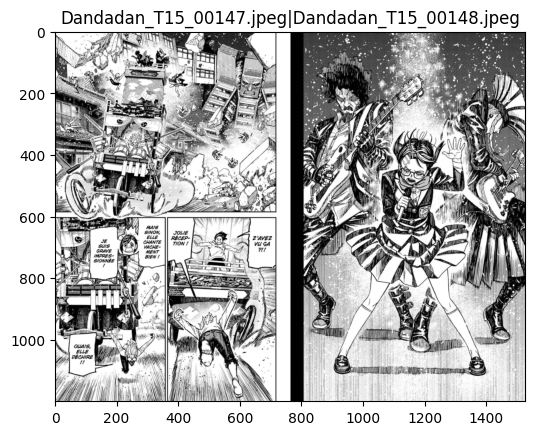

2025/01/17 13:12:18 - INFO: Dorohedoro


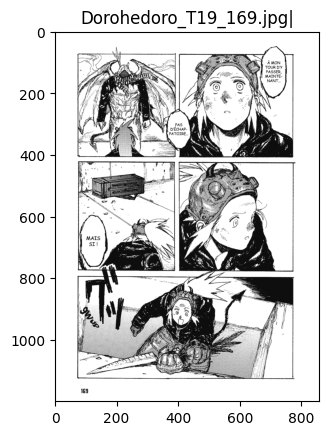

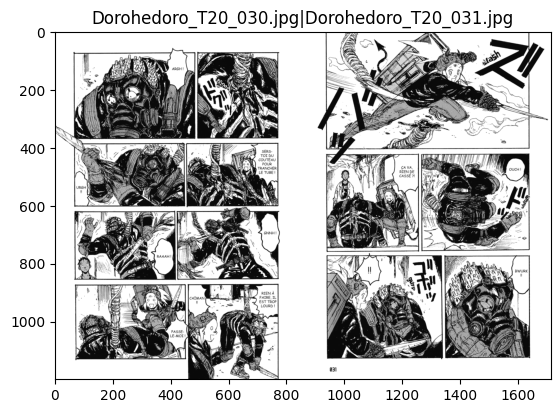

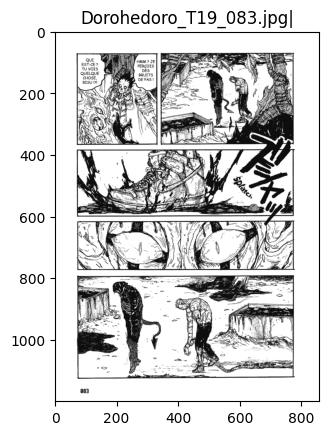

2025/01/17 13:12:19 - INFO: Jujutsu-Kaisen


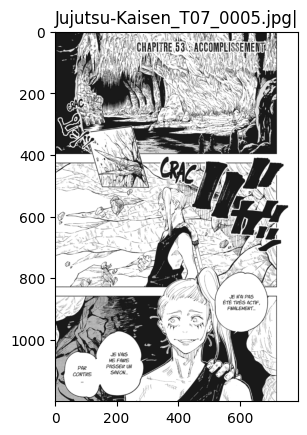

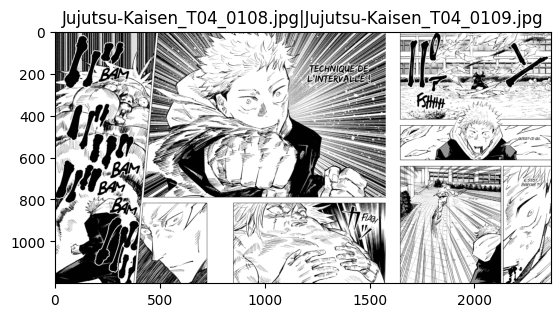

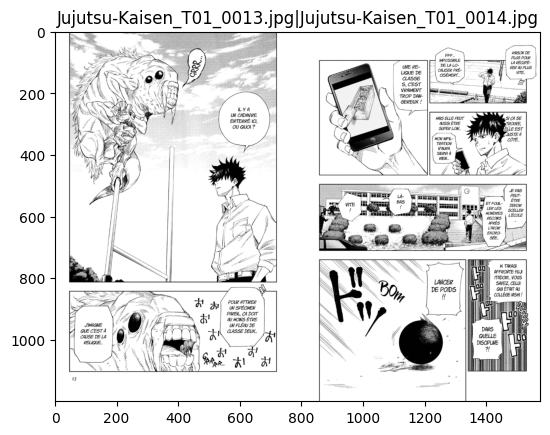

2025/01/17 13:12:20 - INFO: Vagabond


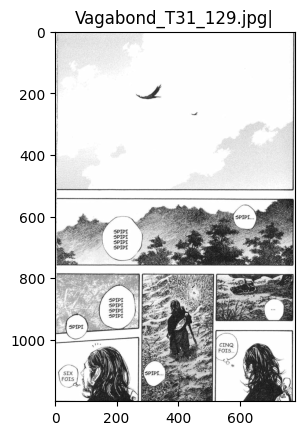

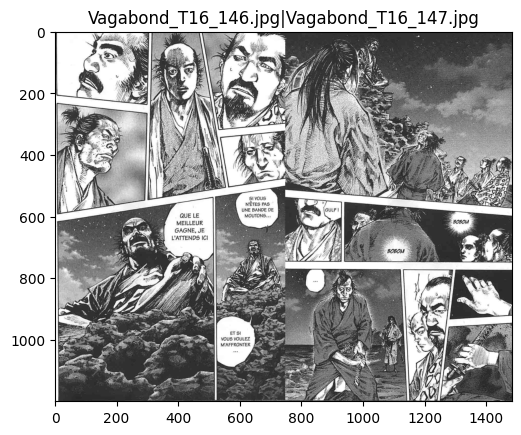

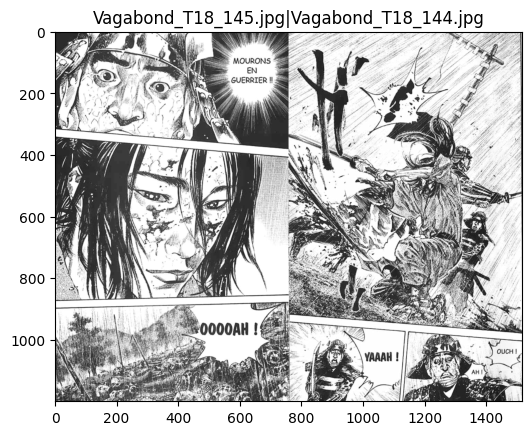

In [22]:
rng = np.random.default_rng(42)
for manga in pd.unique(ds.df["Manga"]):
    logging.info(manga)
    list_idx = rng.choice(ds.df[ds.df["Manga"]==manga].index, 3)
    for k in list_idx:
        fig, ax = plt.subplots(1,1)
        ax.imshow(ds[k]["image"], cmap="gray")
        ax.set_title(ds.df.loc[k, "File_name"] + "|" +ds.df.loc[k, "pairing"])
        plt.show()
        plt.close()
        

In [10]:
ds.df[ds.df["File_name"]=="Jujutsu-Kaisen_T04_0108.jpg"]

File_name           Manga Volume  is_double_page  \
19037  Jujutsu-Kaisen_T04_0108.jpg  Jujutsu-Kaisen    T04           False   

                           pairing  
19037  Jujutsu-Kaisen_T04_0109.jpg

In [13]:
root_data = "/Users/romanmalinowski/Code/Classifier_manga/data/images"
img_0 = ds.imread(os.path.join(root_data, "Jujutsu-Kaisen_T04_0108.jpg"))
            
img_1_name = os.path.join(root_data, "Vagabond_T18_144.jpg")
img_1 = ds.imread(img_1_name)

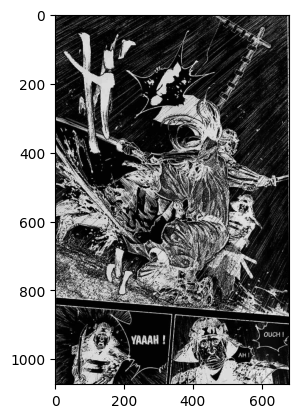

In [9]:
img_gray = np.round(img_1*255, 0).astype(np.uint8)
plt.imshow(img_gray, cmap="gray")

In [22]:
rescale = Rescale(1200)

In [40]:
img_1.shape

(1073, 680)

In [15]:
ds.rescale(img_1).shape, img_1.shape

2025/01/17 13:09:55 - INFO: 1200 - 760


((1200, 760), (1073, 680))

In [10]:
ds.rescale.output_size

1200

In [23]:
Exception

Exception